In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.network as network
import src.network_utils as net_utils

# Convolutional Neural Networks

Convolutional neural networks are networks which include one or more convolutional layers in their architecture. They are especially equipped for handling more complex problems such as image recognition due to their translational invariance. The convolutional layer is implemented as shown below and actually uses the cross-correlation operation for forward propogation and the convolution operation for backpropogation.  

The `Convolutional` layer must be initialized with the shape of the data in the input layer, the size of the kernal, and the number of kernels. Additional layers such as the `Reshape` and `Rescale` layers were also added to help the convolutional network architecture. 

In [ ]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, num_kernels):
        self.num_inputs = input_shape[0]
        self.num_kernels = num_kernels
        self.input_shape = input_shape
        self.output_shape = (num_kernels, input_shape[1] - kernel_size + 1, input_shape[2] - kernel_size + 1)
        self.kernel_shape = (num_kernels, input_shape[0], kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernel_shape)
        self.biases = np.random.randn(*self.output_shape)
        self.nabla_k = 0
        self.nabla_b = 0
        
    def forward(self, x):
        self.input = x
        y = np.zeros(self.output_shape)
        for i in range(self.num_kernels):
            for j in range(self.num_inputs):
                y[i] += signal.correlate2d(self.input[j], self.kernels[i][j], mode='valid')
        return y + self.biases 
    
    def backward(self, nabla_out):
        nabla_k = np.zeros(self.kernel_shape)
        nabla_x = np.zeros(self.input_shape)
        for i in range(self.kernel_shape[0]):
            for j in range(self.input_shape[0]):
                nabla_k[i][j] = signal.correlate2d(self.input[j], nabla_out[i], mode='valid')
                nabla_x[j] += signal.convolve2d(nabla_out[i], self.kernels[i][j], mode='full')
        
        self.nabla_k += nabla_k
        self.nabla_b += nabla_out
        return nabla_x

    def update_params(self, eta, n):
        self.kernels -= eta * self.nabla_k / n
        self.biases -= eta * self.nabla_b / n
        self.nabla_k = 0
        self.nabla_b = 0

## MNIST Dataset

The MNIST dataset is a popular benchmark dataset consisting of labelled images of handwritten digits from 0 to 9. Note that a CSV copy of the dataset was used but is not included in the github repo. The dataset can be downloaded here: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv.   

The following network was used to classify the images based on their corresponding digits. The network architecture consists of a convolutional layer with 3 5x5 kernels followed by a fully connected linear layer with a sigmoid activation function. The network was able to correctly classify over 97% of the handwritten digits.

In [2]:
def load_data(filename, binary=False):
    
    data = pd.read_csv(filename)
    if binary:
        data = data.loc[(data['label'] == 0) | (data['label'] == 1)]
    labels = np.array(data['label'])

    images = data.drop(columns=['label'])
    images = np.array(images).reshape((labels.size, 1, 28, 28)) / 255

    labels = np.array([1 * (np.arange(10).reshape(10,1) == y) for y in labels])

    return images, labels

In [3]:
training_images, training_labels = load_data('data/mnist_train.csv')
test_images, test_labels = load_data('data/mnist_test.csv')

In [10]:
mini_batch_size = 16
eta = 0.2
epochs = 15
error_disp = 3

relu_net = network.Network([network.Convolutional((1,28,28), 5, 3),
                            network.ReLU(),
                            network.Reshape((3, 24, 24), (3*24*24, 1)),
                            network.Linear(3*24*24, 10),
                            network.Sigmoid()])

relu_net.train(training_images, training_labels, mini_batch_size, eta, epochs, error_disp,
          evaluation = 'percentage_onehot', test_data = test_images, test_labels = test_labels)

Accuracy in epoch 1 / 15: 92.05%
Accuracy in epoch 4 / 15: 94.83%
Accuracy in epoch 7 / 15: 96.34%
Accuracy in epoch 10 / 15: 96.74%
Accuracy in epoch 13 / 15: 96.95%
Accuracy in epoch 15 / 15: 97.04%


In [12]:
net_utils.save_network(relu_net, 'out/convolutional_networks/relu_net.obj')

In [4]:
relu_net = net_utils.read_network('out/convolutional_networks/relu_net.obj')

## Visualizing Network

Some sample methods were written to provide a visualization of the network's functionality as well as its kernels and feature maps. Some examples are demonstrated below.

In [14]:
def sample_prediction(net, images, labels):
    index = np.random.randint(0, images.shape[0])
    test_image = images[index]
    test_label = labels[index]
    actual = np.argmax(test_label)
    predicted = np.argmax(relu_net.forward_prop(test_image))
    
    print(f'Actual label: {actual}\nNetwork prediction: {predicted}')
    plt.figure(figsize=(6,6))
    plt.imshow(test_image[0], cmap='gray_r')
    plt.show()
    
    
def display_kernels(net, layer):
    conv_layer = net.layers[layer]
    
    kernels = 0
    for i in range(conv_layer.num_kernels):
        for j in range(conv_layer.num_inputs):
            print(f'Kernel {i}, layer {j}:')
            kernel = conv_layer.kernels[i][j]
            plt.imshow(kernel, cmap='gray_r')
            plt.show()
            
            
def get_kernel_nets(net, layer):
    conv_layer = net.layers[layer]
    
    nets = []
    for i in range(conv_layer.num_kernels):
        input_shape = conv_layer.input_shape
        kernel_size = conv_layer.kernel_shape[2]
        nets.append(network.Network([network.Convolutional(input_shape, kernel_size, 1),
                                     network.Sigmoid()]))
        nets[i].kernels = conv_layer.kernels[i].reshape(1, input_shape[0], kernel_size, kernel_size)
        nets[i].biases = conv_layer.biases[i].reshape(1, input_shape[1]-kernel_size+1, 
                                                      input_shape[2]-kernel_size+1)
        
    return nets


def visualize_kernel_nets(net, layer, images):
    index = np.random.randint(0, images.shape[0])
    test_image = images[index]
    nets = get_kernel_nets(net, layer)
    
    print('Original Image')
    plt.imshow(test_image[0], cmap='gray_r')
    plt.show()
    print('Feature Maps')
    
    for net in nets:
        out = net.forward_prop(test_image)[0]
        plt.imshow(out, cmap='gray_r')
        plt.show()

Actual label: 5
Network prediction: 5


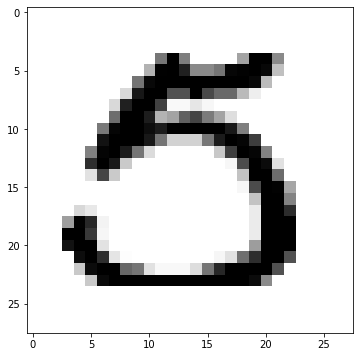

In [9]:
sample_prediction(relu_net, test_images, test_labels)

Kernel 0, layer 0:


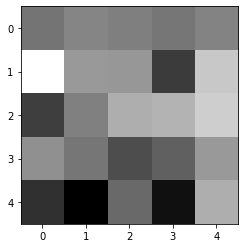

Kernel 1, layer 0:


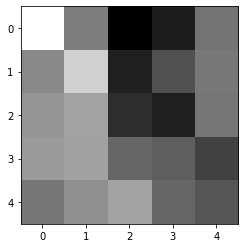

Kernel 2, layer 0:


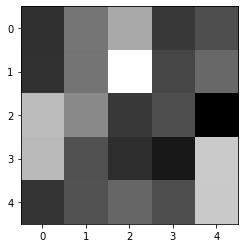

In [10]:
display_kernels(relu_net, 0)

Original Image


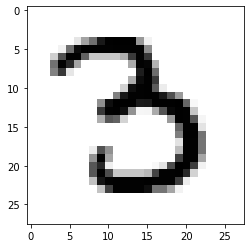

Feature Maps


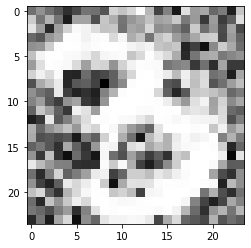

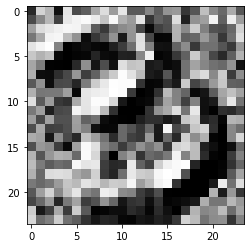

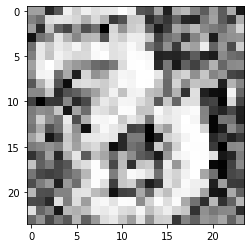

In [15]:
visualize_kernel_nets(relu_net, 0, test_images)

## Fully Convolutional Network

One of the main objectives of this research project was to create a convolutional network that was fully convolutional. This would imply that no fully connected linear layer be used to reduce the output size of the network. The `Summation` layer shown below was constructed to be able to take an arbitrary sized $ n\times k\times j $ layer and convert it to an $ n\times 1 \times 1 $ sized layer by summing over the second and third dimensions.  

The network being fully convolutional would theoretically allow it to produce similar outputs with images of varying size. To implement this, an updated convolutional layer which does not require this dimensions of the input layer would be required.  

An attempted architecture for a fully convolutional network is shown below and makes use of the `Rescale` and `Summation` layers. Some additional testing and training time would be required to produce a functioning network.

In [ ]:
class Summation(Layer):
    def __init__(self):
        pass
        
    def forward(self, x):
        self.input = x
        return np.sum(self.input, axis=(1,2)).reshape(self.input.shape[0], 1)
    
    def backward(self, nabla_out):
        in_shape = self.input.shape
        nabla_in = np.ones(in_shape)
        return np.array([nabla_in[i] * nabla_out[i] for i in range(len(nabla_out))])
    
    def update_params(self, eta, n):
        pass

In [18]:
mini_batch_size = 16
eta = 8
epochs = 5
error_disp = 1

fcn = network.Network([network.Convolutional((1,28,28), 5, 6),
                       network.ReLU(),
                       network.Rescale(2),
                       network.Convolutional((6,12,12), 5, 10),
                       network.ReLU(),
                       network.Rescale(2),
                       network.Summation(),
                       network.Sigmoid()])

fcn.train(training_images, training_labels, mini_batch_size, eta, epochs, error_disp, 
          evaluation='percentage_onehot', test_data = test_images, test_labels = test_labels)

Accuracy in epoch 1 / 5: 9.82%
Accuracy in epoch 2 / 5: 9.82%
Accuracy in epoch 3 / 5: 9.82%
Accuracy in epoch 4 / 5: 9.82%
Accuracy in epoch 5 / 5: 9.82%


In [20]:
net_utils.save_network(fcn, 'out/convolutional_networks/fcn.obj')

In [21]:
fcn = net_utils.read_network('out/convolutional_networks/fcn.obj')